# 模型选择，欠拟合过拟合

In [154]:
from torch import nn
from d2l import torch as d2l
import numpy as np
import torch
import math

#### 拟合一个多项式：$y=5+1.2x-3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+\omega$ ，$\omega$正态分布噪声项

##### 参考案例：书上代码

In [233]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
labels

array([  5.2246518 ,   0.51461205,  -0.68522845,   3.02085393,
         1.91411005, -26.9304453 ,   5.82726389,  -0.54785346,
        -1.57877039,   4.52762953,  -1.05032034,   5.39951609,
         4.85337757,   3.98721461,   3.59306245,   1.64457544,
         0.96071486,   6.53885398,   5.3292633 ,   7.78067194,
         4.6355657 ,   5.32273017,   5.10530834,   5.07395777,
         3.45859134,   4.86326773,   2.63548695,   5.15712564,
         5.0575505 ,   5.43000591,   7.56862095,   4.49174295,
         6.49106415,   1.96320558,  -3.45515627,   2.49739227,
         4.91234956,   5.49833621,   5.64775647,   5.1216091 ,
         1.27201813,   5.00948269,   1.03614727,   6.4499716 ,
         4.52303427,   3.10754193,   4.80835099,   5.06655467,
         5.34036942,   5.24204955,  -4.57903827,   6.67334626,
         1.43371426,   2.24903981,   5.41447528,   5.17607139,
         4.71204064,   9.48130899,   4.89487196,   5.23992823,
         5.17151986,   4.44678905,   5.76858136,   3.76

In [234]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.5734],
         [-1.0685]]),
 tensor([[ 1.0000e+00,  5.7335e-01,  1.6437e-01,  3.1413e-02,  4.5027e-03,
           5.1632e-04,  4.9339e-05,  4.0412e-06,  2.8963e-07,  1.8451e-08,
           1.0579e-09,  5.5140e-11,  2.6345e-12,  1.1619e-13,  4.7585e-15,
           1.8189e-16,  6.5178e-18,  2.1982e-19,  7.0020e-21,  2.1129e-22],
         [ 1.0000e+00, -1.0685e+00,  5.7088e-01, -2.0333e-01,  5.4317e-02,
          -1.1608e-02,  2.0672e-03, -3.1556e-04,  4.2148e-05, -5.0040e-06,
           5.3469e-07, -5.1939e-08,  4.6249e-09, -3.8014e-10,  2.9014e-11,
          -2.0668e-12,  1.3803e-13, -8.6757e-15,  5.1501e-16, -2.8964e-17]]),
 tensor([5.2247, 0.5146]))

In [235]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [236]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.993523   1.240014  -3.418196   5.5388384]]


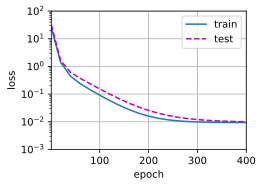

In [237]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

In [240]:
max_degree=20
n_train,n_test=100,100
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])
feature=np.random.normal(size=(n_test+n_train,1))
np.random.shuffle(feature)
poly_feature=np.power(feature,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_feature[:,i]/=math.gamma(i+1)

labels=np.dot(poly_feature,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)

In [241]:
true_w,poly_feature,labels,feature=[torch.tensor(x,dtype=torch.float32) for x in [true_w,poly_feature,labels,feature]]

weight: [[ 3.8846273   0.16500577 -0.5566638   0.5963539   1.9176387  -0.68961513
   0.46130246 -0.4275862   0.2737848   0.04800932]]


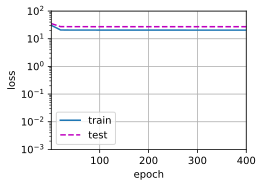

In [243]:
def eval_loss(net,,):
    

weight: [[ 4.987186   1.173823  -3.4076784  5.6323323]]


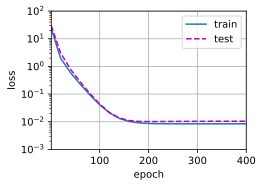